In [13]:
# import numpy, matplotlib, and other things necessary for simulating a game of battleship
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm import tqdm

np.random.seed(298)

In [14]:
# define the ship size
ship_sizes = [(5, 1), (4, 1), (3, 1), (3, 1), (2, 1)]
num_ships = len(ship_sizes)
board_size = 10

# place two random ships on the board
def generate_board(board_size=board_size, num_ships=num_ships, ship_sizes=ship_sizes):
    board = np.zeros((board_size, board_size))
    for i in range(num_ships):
        ship_size = ship_sizes[i]
        if np.random.rand() > 0.5:
            ship_size = ship_size[::-1]
        ship = np.random.randint(0, board_size, 2) # Place ship

        # Check if ship would overlap with existing ships or be adjacent to them
        while (ship[0] + ship_size[0] > board_size or 
            ship[1] + ship_size[1] > board_size or 
            np.any(board[max(0, ship[0]-1):min(board_size, ship[0]+ship_size[0]+1),
                        max(0, ship[1]-1):min(board_size, ship[1]+ship_size[1]+1)] > 0)):
            
            ship = np.random.randint(0, board_size, 2) # Place ship

        board[ship[0]:ship[0]+ship_size[0], ship[1]:ship[1]+ship_size[1]] = 1 # Mark grid as occupied
    
    return board

board = generate_board(board_size, num_ships)

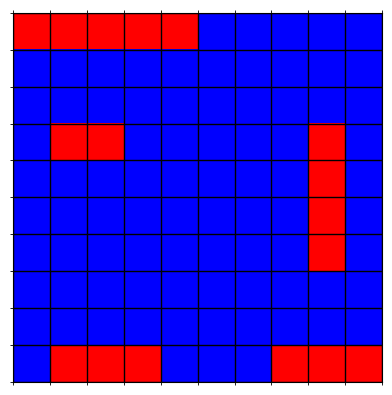

In [15]:
def generate_plot(board, board_size=board_size):
    # create figure and axis
    fig, ax = plt.subplots()

    # create a matrix plot of the board
    cmap = colors.ListedColormap(['blue', 'red'])
    ax.matshow(board, cmap=cmap)

    # put grid lines in plot
    ax.grid(True, which='both', color='black', linewidth=1)

    # Set the ticks to be at the center of each cell
    ax.set_xticks(np.arange(-.5, board_size, 1), minor=True)
    ax.set_yticks(np.arange(-.5, board_size, 1), minor=True)

    # Remove major tick labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

generate_plot(board)

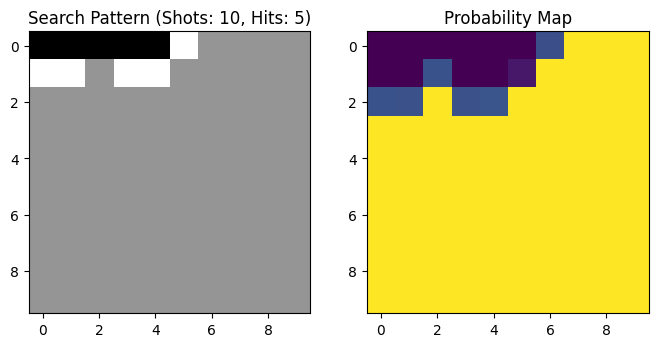

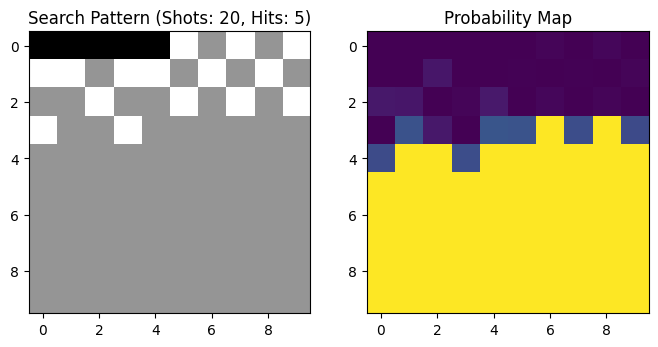

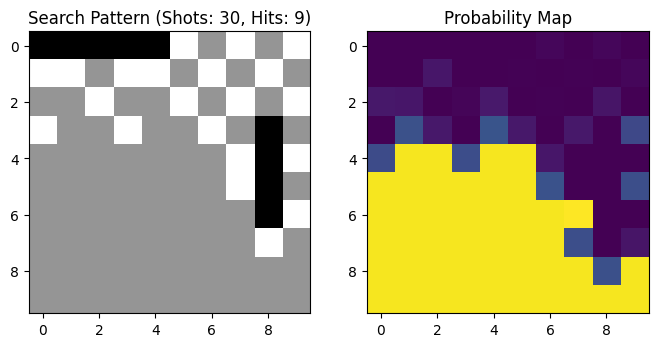

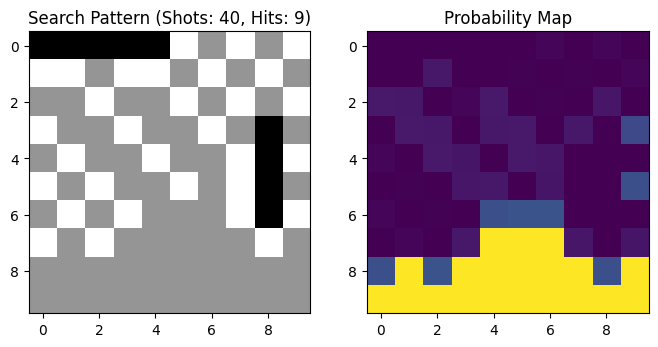

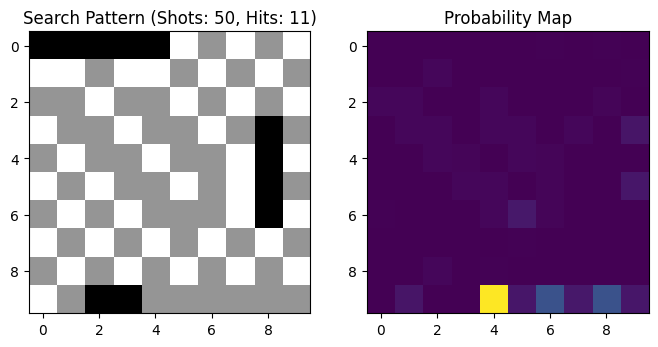

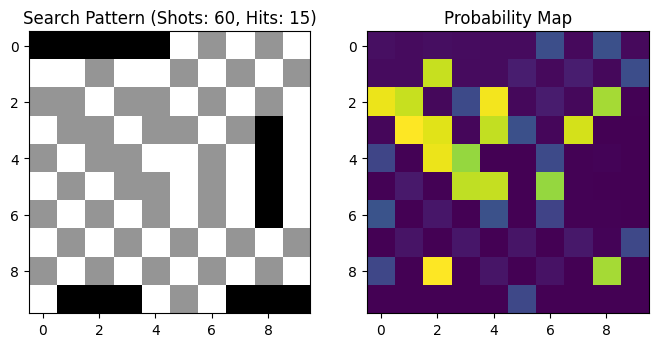

Found all ships in 63 shots


In [16]:
# Generate uniform prior
uniform_prob_map = np.ones((board_size, board_size)) / (board_size * board_size)

def bayesian_search(prob_map=uniform_prob_map, board=board, noise=0.01, visualize=True, board_size=board_size):
    # Initialize probability distribution (uniform prior)
    # prob_map = np.ones((board_size, board_size)) / (board_size * board_size)
    
    # Initialize hit map to track shots
    hit_map = np.zeros((board_size, board_size))
    
    # Prior knowledge: ships are more likely to be in lines
    def update_probabilities(prob_map, x, y, hit):
        # Update based on hit or miss
        if hit:
            # If hit, increase probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size and hit_map[new_x, new_y] == 0:
                    prob_map[new_x, new_y] *= 4 + np.random.normal(0, noise)
        else:
            # If miss, decrease probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size:
                    prob_map[new_x, new_y] *= 0.25 + np.random.normal(0, noise)
        
        # Normalize probabilities
        prob_map = prob_map / np.sum(prob_map) + 1e-6  # div by 0
        return prob_map
    
    # Simulate search
    shots = 0
    hits = 0
    while hits < np.sum(board):  # Continue until all ships are found
        # Find highest probability location
        x, y = np.unravel_index(np.argmax(prob_map), prob_map.shape)
        
        # Take shot
        hit = board[x, y] == 1
        hit_map[x, y] = 1 if hit else -1
        shots += 1
        
        if hit:
            hits += 1
        
        # Update probabilities
        prob_map[x, y] = 0  # Zero out probability of searched location
        prob_map = update_probabilities(prob_map, x, y, hit)
        
        # Visualize current state (optional)
        if visualize and shots % 10 == 0:  # Show every 10 shots
            plt.figure(figsize=(8, 4))
            
            plt.subplot(121)
            plt.imshow(hit_map, cmap='Greys')
            plt.title(f'Search Pattern (Shots: {shots}, Hits: {hits})')
            
            plt.subplot(122)
            plt.imshow(prob_map, cmap='viridis')
            plt.title('Probability Map')
            
            plt.show()
    
    return shots, hit_map

# Run the search on a uniform prior
shots, final_pattern = bayesian_search()
print(f"Found all ships in {shots} shots")

# welcome to ml

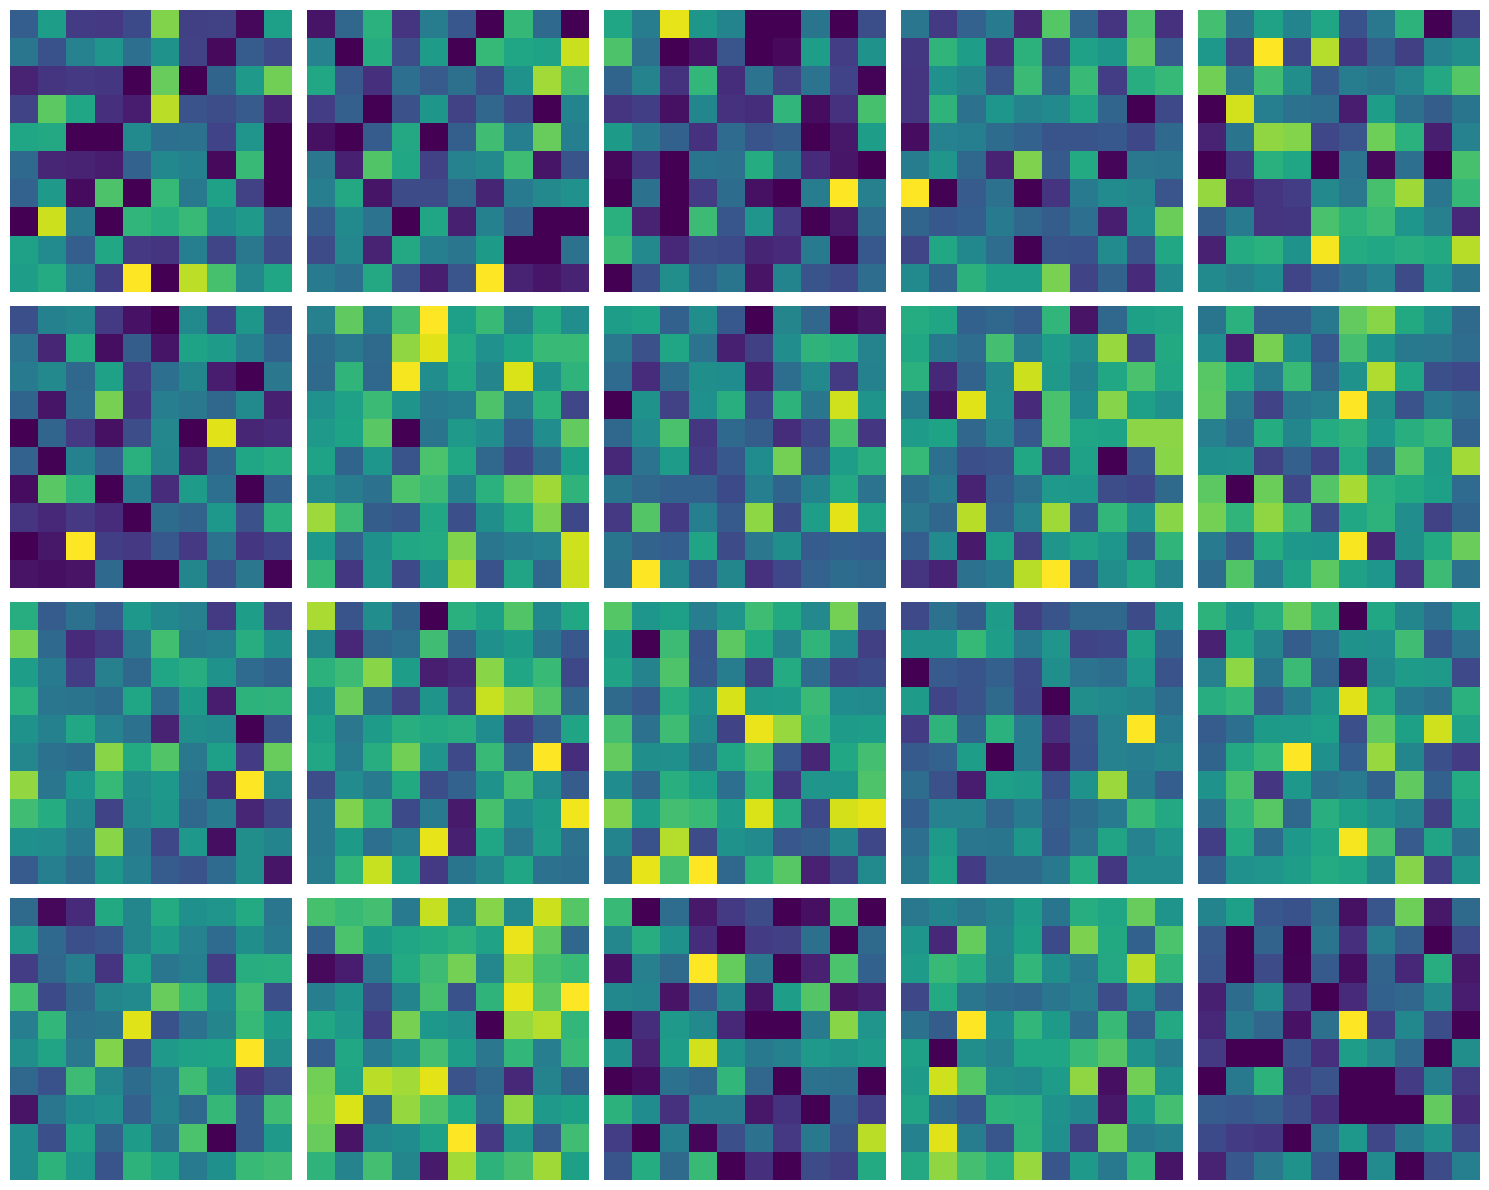

In [17]:
# Generate 20 random priors with noise
n_priors = 20
priors = []

# Noise should be randomly sampled from a normal distribution with a standard deviation of 0.1
noise_levels = np.random.uniform(0, 0.01, n_priors)

# Create figure
fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.ravel()

for i in range(n_priors):
    # Start with uniform distribution
    prior = np.ones((board_size, board_size)) / (board_size * board_size)
    
    # Add random noise
    noise = np.random.normal(0, noise_levels[i], (board_size, board_size))
    prior += noise
    
    # Ensure all probabilities are positive
    prior = np.maximum(prior, 0)
    
    # Normalize
    prior = prior / np.sum(prior)
    
    priors.append(prior)
    
    # Plot
    im = axs[i].imshow(prior, cmap='viridis')
    axs[i].axis('off')

good_init_priors = priors

plt.tight_layout()
plt.show()

In [18]:
# Generate 100 sample boards
def generate_100_sample_boards():
    return [generate_board() for _ in range(100)]

test_boards = generate_100_sample_boards()
print(f"Generated {len(test_boards)} sample boards")

# for board in test_boards[:3]:
#     generate_plot(board)

Generated 100 sample boards


20it [00:01, 11.32it/s]

Best performing prior: 12
Average shots needed: 66.29 ± 7.97


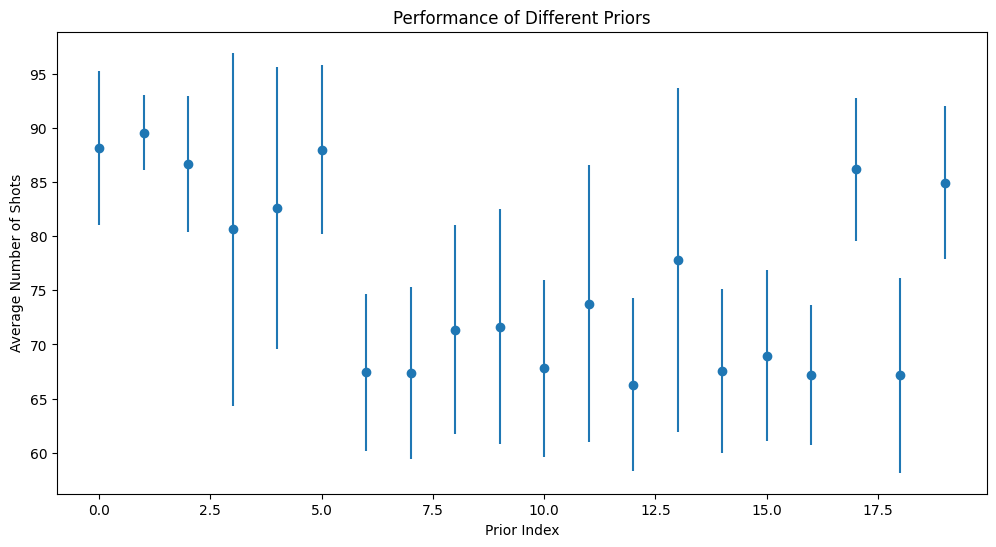

In [19]:
# Initialize array to store results
results = np.zeros((len(priors), len(test_boards)))

# For each prior and test board
for i, prior in tqdm(enumerate(priors)):
    for j, test_board in enumerate(test_boards):
        # Run bayesian search with this prior
        shots, _ = bayesian_search(prior.copy(), test_board, visualize=False)
        results[i, j] = shots

# Calculate statistics for each prior
mean_shots = np.mean(results, axis=1)
std_shots = np.std(results, axis=1)

# Plot results
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(priors)), mean_shots, yerr=std_shots, fmt='o')
plt.xlabel('Prior Index')
plt.ylabel('Average Number of Shots')
plt.title('Performance of Different Priors')

# Find best performing prior
best_prior_idx = np.argmin(mean_shots)
print(f"Best performing prior: {best_prior_idx}")
print(f"Average shots needed: {mean_shots[best_prior_idx]:.2f} ± {std_shots[best_prior_idx]:.2f}")

In [20]:
# Take 4 best priors
best_priors = np.argsort(mean_shots)[:4]
best_prior_boards = [priors[i] for i in best_priors]

#! TODO: replace random noise w/ likelihoods
# function to add noise to each of these priors
def add_noise(prior, noise_level):
    # Add random noise
    noise = np.random.normal(0, noise_level, (board_size, board_size))
    prior += noise

    # Ensure all probabilities are positive
    prior = np.maximum(prior, 0)

    # Normalize
    prior = prior / np.sum(prior)

    return prior

posteriors = [add_noise(p, .01) for p in best_prior_boards]

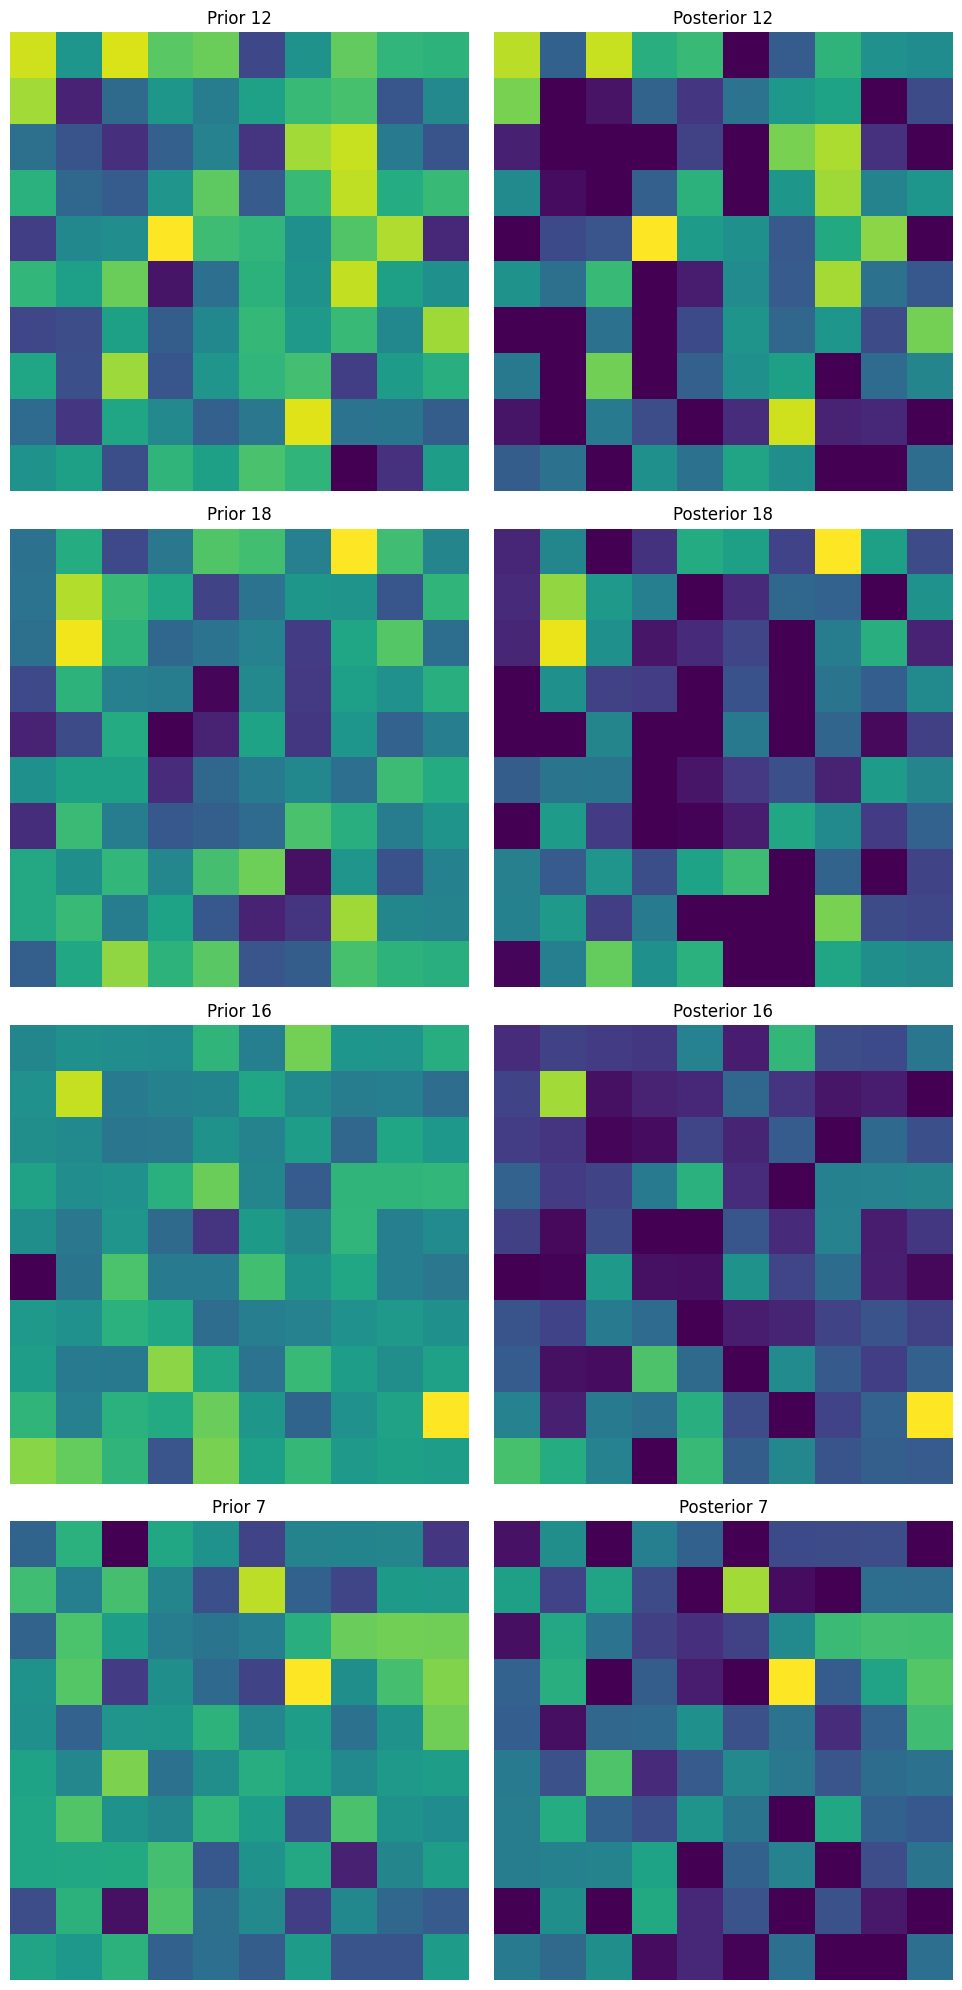

In [21]:
# before and after comparison
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.ravel()

for i, prior_idx in enumerate(best_priors):
    # Plot prior
    im = axs[2*i].imshow(priors[prior_idx], cmap='viridis')
    axs[2*i].axis('off')
    axs[2*i].set_title(f'Prior {prior_idx}')
    
    # Plot posterior
    im = axs[2*i+1].imshow(posteriors[i], cmap='viridis')
    axs[2*i+1].axis('off')
    axs[2*i+1].set_title(f'Posterior {prior_idx}')

plt.tight_layout()
plt.show()

In [ ]:
# do this loop 50 times
n_iters = 50
shots_needed = []
posteriors = good_init_priors

for i in tqdm(range(n_iters)):
    sample_boards = generate_100_sample_boards()
    results = np.zeros((len(posteriors), len(sample_boards)))

    for j, posterior in enumerate(posteriors):
        for k, sample_board in enumerate(sample_boards):
            shots, _ = bayesian_search(posterior.copy(), sample_board, noise=0.1, visualize=False)
            results[j, k] = shots

    mean_shots = np.mean(results, axis=1)
    std_shots = np.std(results, axis=1)
    best_prior_idx = np.argmin(mean_shots)

    # Update best priors
    best_priors = np.argsort(mean_shots)[:4]

    best_prior_boards = []
    for idx in best_priors:
        for _ in range(5):  # create 5 boards from each prior
            best_prior_boards.append(priors[idx])
    posteriors = [add_noise(p, .01) for p in best_prior_boards]

    shots_needed.append(mean_shots[best_prior_idx])
    

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


[73.64, 73.53, 75.07, 73.66, 71.51, 74.11, 75.31, 74.43, 74.36, 71.13, 74.12, 74.23, 74.97, 74.44, 73.53, 76.57, 75.58, 73.97, 73.23, 74.61, 75.64, 73.39, 75.34, 74.52, 74.7, 76.72, 73.71, 74.12, 74.69, 72.48, 75.82, 74.82, 74.66, 74.6, 75.47, 75.59, 74.19, 70.35, 75.13, 75.58, 75.63, 74.23, 72.67, 74.75, 74.12, 73.65, 72.8, 71.91, 74.6, 72.96]


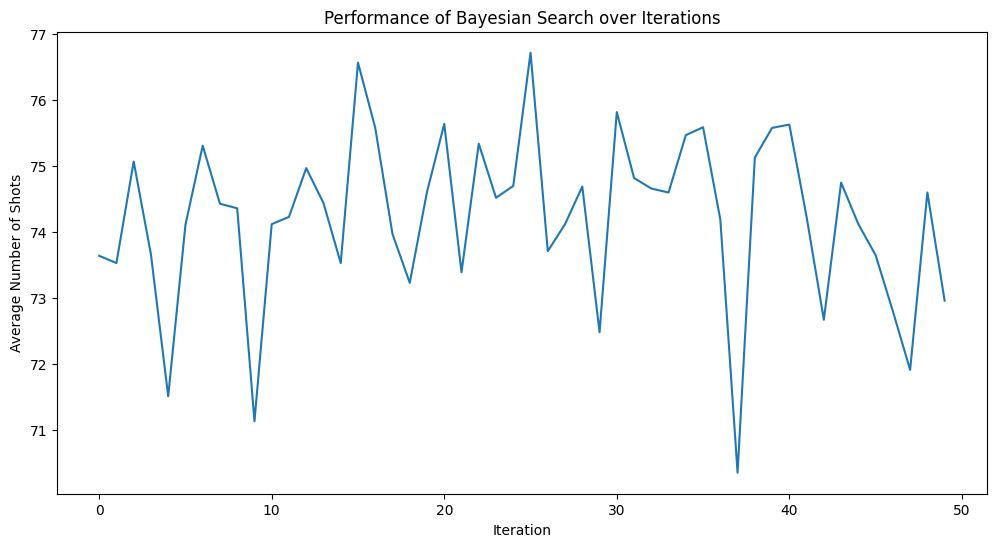

In [28]:
print([round(float(f), 2) for f in shots_needed])

# Plot results over iterations
plt.figure(figsize=(12, 6))
plt.plot(shots_needed)
plt.xlabel('Iteration')
plt.ylabel('Average Number of Shots')
plt.title('Performance of Bayesian Search over Iterations')
plt.show()